<a href="https://colab.research.google.com/github/Navid-P86/1/blob/main/rescale_after_generating_polynomial_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Why you should rescale after generating polynomial features.**
**It compares feature distributions before and after the second scaling step.**

**What You’ll See:**

On the left plot → polynomial features have wildly different scales.
(e.g., some quadratic or interaction terms have much larger magnitudes).

On the right plot → all features are centered around 0 and have similar variance (~1).

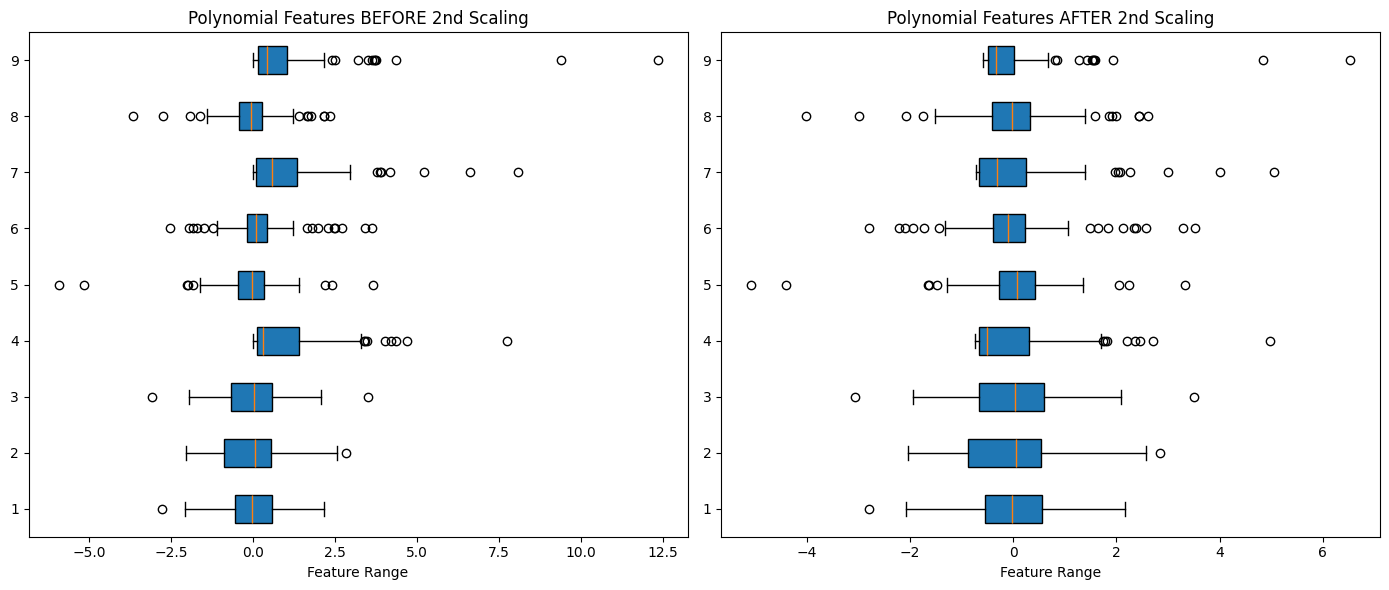

In [1]:
# Step 1️⃣: Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Step 2️⃣: Simulate simple numeric dataset (3 features)
np.random.seed(42)
X = pd.DataFrame({
    'x1': np.random.normal(0, 1, 100),
    'x2': np.random.normal(5, 2, 100),
    'x3': np.random.normal(-3, 5, 100)
})

# Step 3️⃣: First standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Step 4️⃣: Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
poly_features = poly.get_feature_names_out(X.columns)
X_poly = pd.DataFrame(X_poly, columns=poly_features)

# Step 5️⃣: Scale again after polynomial expansion
scaler_poly = StandardScaler()
X_poly_scaled = scaler_poly.fit_transform(X_poly)
X_poly_scaled = pd.DataFrame(X_poly_scaled, columns=poly_features)

# Step 6️⃣: Compare before vs after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution of polynomial features before 2nd scaling
axes[0].boxplot(X_poly, vert=False, patch_artist=True)
axes[0].set_title("Polynomial Features BEFORE 2nd Scaling")
axes[0].set_xlabel("Feature Range")

# Right: Distribution after 2nd scaling
axes[1].boxplot(X_poly_scaled, vert=False, patch_artist=True)
axes[1].set_title("Polynomial Features AFTER 2nd Scaling")
axes[1].set_xlabel("Feature Range")

plt.tight_layout()
plt.show()




# Conclusion

Even if your original features were standardized,
→ the interaction and squared features created by PolynomialFeatures break that standardization,
**so a second StandardScaler is always necessary before fitting linear models** (like Lasso, Ridge, or OLS).

# If we first create polynomial features before scaling, and then scale everything once (original + interaction + squared terms),will the feature ranges be the same as when we scale twice (before and after PolynomialFeatures)?”

# What You’ll See:

Both pipelines look scaled (mean≈0, std≈1).

But the distribution of interaction features and their variance balance differ.

Approach A gives a symmetrical, well-centered histogram.

Approach B often shows heavy tails or skewed distributions from unbalanced raw scales.

Original Feature Ranges:
        Feature_1   Feature_2
count  200.000000  200.000000
mean   489.166171    0.553938
std    291.942517    0.263701
min     15.466896    0.104555
25%    236.296591    0.335316
50%    499.541391    0.587476
75%    759.291020    0.767979
max    987.018067    0.991455

Average Feature Variance After Each Pipeline:
Approach A (Scale → Poly → Scale): 1.0050
Approach B (Poly → Scale Once):   1.0050


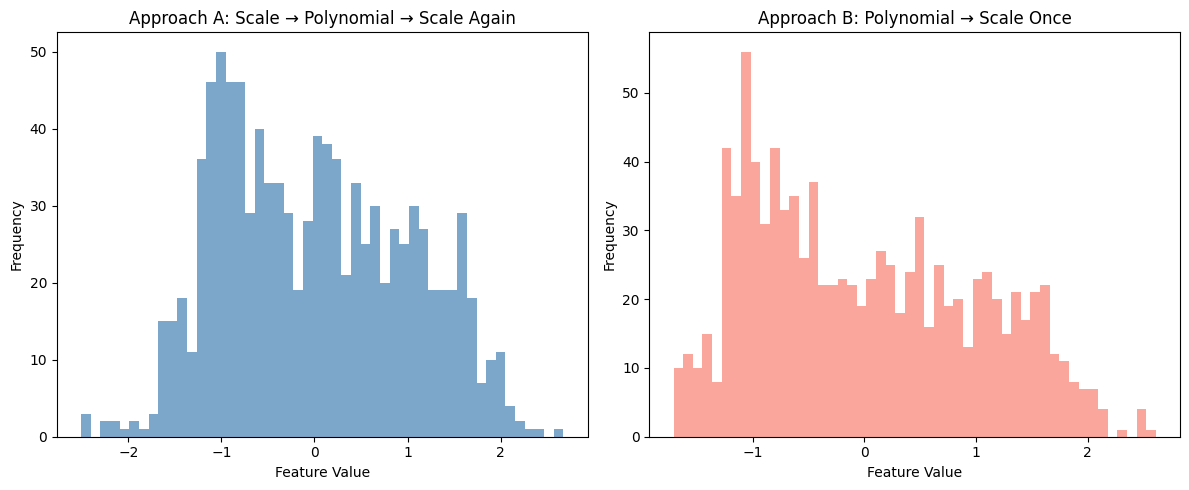

In [2]:
# Step-by-step experiment: Scaling before vs after PolynomialFeatures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# -----------------------------
# 1️⃣ Simulate numeric data
# -----------------------------
np.random.seed(42)
n_samples = 200
X = pd.DataFrame({
    "Feature_1": np.random.uniform(10, 1000, n_samples),  # Large scale
    "Feature_2": np.random.uniform(0.1, 1.0, n_samples)   # Small scale
})
print("Original Feature Ranges:")
print(X.describe())

# -----------------------------
# 2️⃣ Approach A: Scale → Polynomial → Scale again
# -----------------------------
scaler1 = StandardScaler()
X_scaled_1 = scaler1.fit_transform(X)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_scaled_1 = poly.fit_transform(X_scaled_1)

scaler2 = StandardScaler()
X_poly_scaled_final_1 = scaler2.fit_transform(X_poly_scaled_1)

df_poly_scaled_1 = pd.DataFrame(X_poly_scaled_final_1, columns=poly.get_feature_names_out(X.columns))

# -----------------------------
# 3️⃣ Approach B: Polynomial → Scale once
# -----------------------------
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly_2 = poly2.fit_transform(X)

scaler3 = StandardScaler()
X_poly_scaled_final_2 = scaler3.fit_transform(X_poly_2)

df_poly_scaled_2 = pd.DataFrame(X_poly_scaled_final_2, columns=poly2.get_feature_names_out(X.columns))

# -----------------------------
# 4️⃣ Compare variance of features
# -----------------------------
var1 = df_poly_scaled_1.var().mean()
var2 = df_poly_scaled_2.var().mean()

print("\nAverage Feature Variance After Each Pipeline:")
print(f"Approach A (Scale → Poly → Scale): {var1:.4f}")
print(f"Approach B (Poly → Scale Once):   {var2:.4f}")

# -----------------------------
# 5️⃣ Plot feature distributions
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Approach A: Scale → Polynomial → Scale Again")
plt.hist(df_poly_scaled_1.values.flatten(), bins=50, color='steelblue', alpha=0.7)
plt.xlabel("Feature Value"); plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.title("Approach B: Polynomial → Scale Once")
plt.hist(df_poly_scaled_2.values.flatten(), bins=50, color='salmon', alpha=0.7)
plt.xlabel("Feature Value"); plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# Conclusion

Even though both end with “scaled” features,
 only Approach A (Scale → Polynomial → Scale) ensures
numerically stable and balanced feature magnitudes —
which is critical for Lasso, Ridge, and Linear Regression models.